In [2]:
import numpy as np
import COMSTABPY as csb
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
#load the stability analysis module
stb = csb.comstab()

In [4]:
#load the data
ncname = 'result_deep_summer.nc'
ds = xr.open_dataset(ncname)
time = np.array(ds['time'][:])
depth = np.array(ds['depth'][:])

In [5]:
#communities names: phytoplankton, zooplankton, total(B+P+Z)
communities = ['P','Z','TOT']

In [25]:
#create arrays where to save results
#we will save the mean along the depth axis and the standard deviation
cvs_arr = np.zeros((len(communities),len(depth),4)) #CV_e,CV_tilde,CV_a,CV_c
stb_arr = np.zeros((len(communities),len(depth),4)) #tau,Delta,psi,omega
rel_arr = np.zeros((len(communities),len(depth),3)) #relative Delta,psi,omega
tay_arr = np.zeros((len(communities),len(depth),3)) #b,a,p-value of Taylor's power law

In [26]:
%%capture  
#suppress the output of the loop, to avoid printing warning messages from the stability analysis
#loop over the communities and perform the stability analysis
for icomm,community in enumerate(communities):
    data = np.array(ds[community])[:,:,:]
    #loop over the depth
    for idepth in range(data.shape[2]):
        try:
            #remove rows with all nan values of temporal axis of data
            mask = np.isnan(data[:,:,idepth]).all(axis=1)
            result = stb.partition(data[~mask,:,idepth],stamp=False)
            cvs_arr[icomm,idepth] = result['CVs']
            stb_arr[icomm,idepth] = result['Stabilization']
            rel_arr[icomm,idepth] = result['Relative']
            tay_arr[icomm,idepth] = result['Taylor']
        except:
            cvs_arr[icomm,idepth] = np.array([np.nan,np.nan,np.nan,np.nan])
            stb_arr[icomm,idepth] = np.array([np.nan,np.nan,np.nan,np.nan])
            rel_arr[icomm,idepth] = np.array([np.nan,np.nan,np.nan])
            tay_arr[icomm,idepth] = np.array([np.nan,np.nan,np.nan])
            continue
    

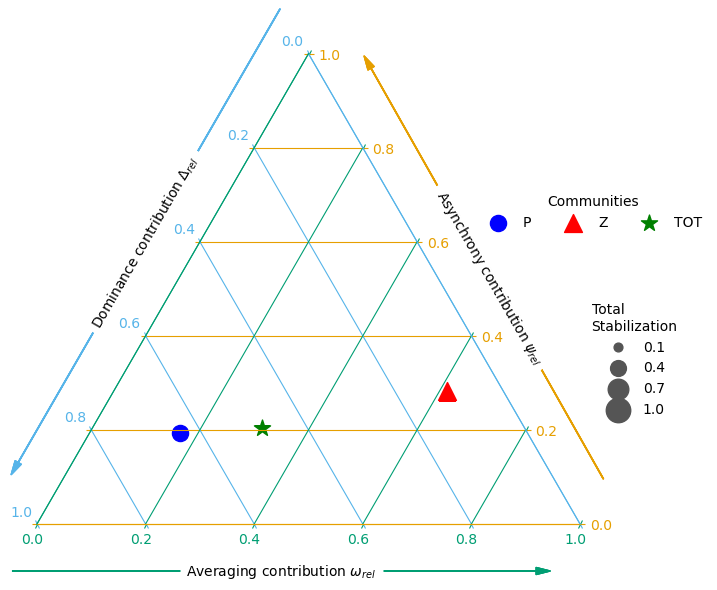

In [27]:
#Ternary plot
#please use numpy arrays for markers, labels and colors
markers = np.array(['o','^','*']) #use a different marker for each community
labels = np.array(['P','Z','TOT']) #label the communities
colors = np.array(['blue','red','green']) #use a different color for each community

stb_mean = np.nanmean(stb_arr,axis=1)
arr_tau = stb_mean[:,0]

rel_mean = np.nanmean(rel_arr,axis=1)
rel_std = np.nanstd(rel_arr,axis=1)

fig,ax = stb.ternaryplot(res=rel_mean,tau=arr_tau,sizelegend=True,marker=markers,labels=labels,color=colors,figname='ternary.png')


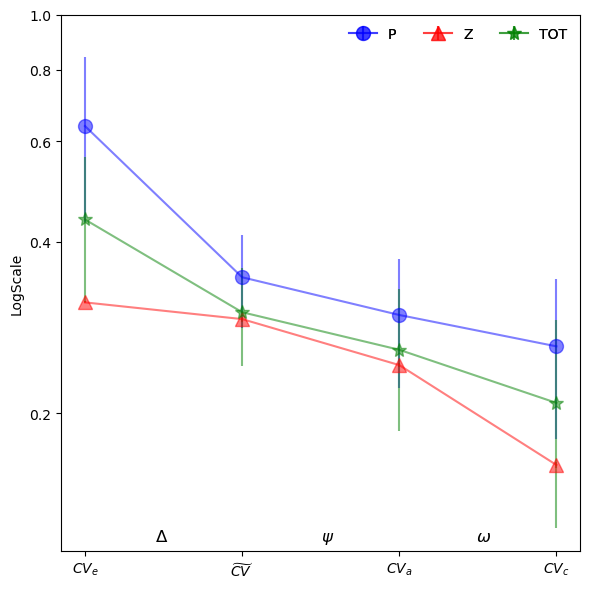

In [28]:
#Plot the CVs using the standard deviation as errorbars
cvs_mean = np.nanmean(cvs_arr,axis=1)
cvs_std = np.nanstd(cvs_arr,axis=1)
fig,ax = stb.plotCV(CV_arr=cvs_mean,ylabel='LogScale',errorbar=cvs_std,marker=markers,labels=labels,color=colors,figname='CVs.png')



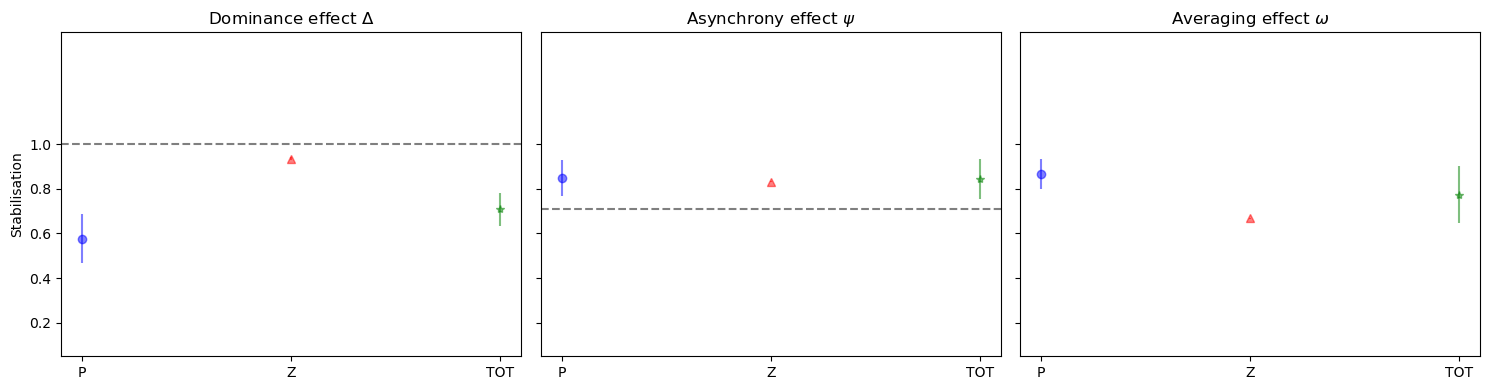

In [29]:
#Plot the stabilzing effects using the standard deviation as errorbars
effects = stb_mean[:,1:] #Delta,psi,omega
stb_std = np.nanstd(stb_arr,axis=1)
errors = stb_std[:,1:]   #Delta,psi,omega
fig,ax = stb.plotEFFECT(EFF=effects,ylogscale=False,errorbar=errors,marker=markers,labels=labels,color=colors,figname='effect.png')


In [30]:
#Perform Tukey's test
#on Delta, comparing the three communities, using the depth as samples
tukey_std = stb.Tukey(stb_arr[:,:,1], labels=labels, savecsv=True, csvname='std_Tukey.csv')
#show the p-values
tukey_std 

,P,Z,TOT
P,1.000000,0.000014,0.000033
Z,0.000014,1.000000,0.005699
TOT,0.000033,0.005699,1.000000


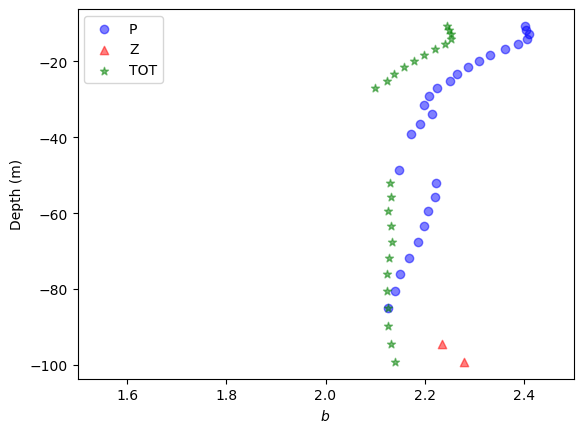

In [34]:
#Plot of Taylor's parameter b along the water column
depth = ds.depth.values
fig,axs = plt.subplots()
for icomm,community in enumerate(communities):
        axs.scatter(tay_arr[icomm,:,0], depth, c=colors[icomm], marker=markers[icomm], alpha=0.5, label=community)
#axs[0].legend()
axs.set_ylabel('Depth (m)')
axs.set_xlabel('$b$')
#    ax.set_xscale('log')
axs.set_xlim(1.5,2.5)
axs.legend()

/var/folders/yw/8trqvgl17sq4f_7s_whdp6_w0000gr/T/ipykernel_4081/3268334378.py:9: RuntimeWarning: Mean of empty slice
  mean_biomass = np.nanmean(ds[community][:,:,iz],axis=1)
/opt/miniconda3/envs/stab-py/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/yw/8trqvgl17sq4f_7s_whdp6_w0000gr/T/ipykernel_4081/3268334378.py:10: RuntimeWarning: Mean of empty slice
  cv_biomass   = np.nanstd(ds[community][:,:,iz],axis=1)/np.nanmean(ds[community][:,:,iz],axis=1)
/var/folders/yw/8trqvgl17sq4f_7s_whdp6_w0000gr/T/ipykernel_4081/3268334378.py:11: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_biomass  = np.nanvar(ds[community][:,:,iz],axis=1)
/var/folders/yw/8trqvgl17sq4f_7s_whdp6_w0000gr/T/ipykernel_4081/3268334378.py:9: RuntimeWarning: Mean of empty slice
  mean_biomass = np.nanmean(ds[community][:,:,iz],axis=1)
/opt/miniconda3/envs/stab-py/lib/python3.8

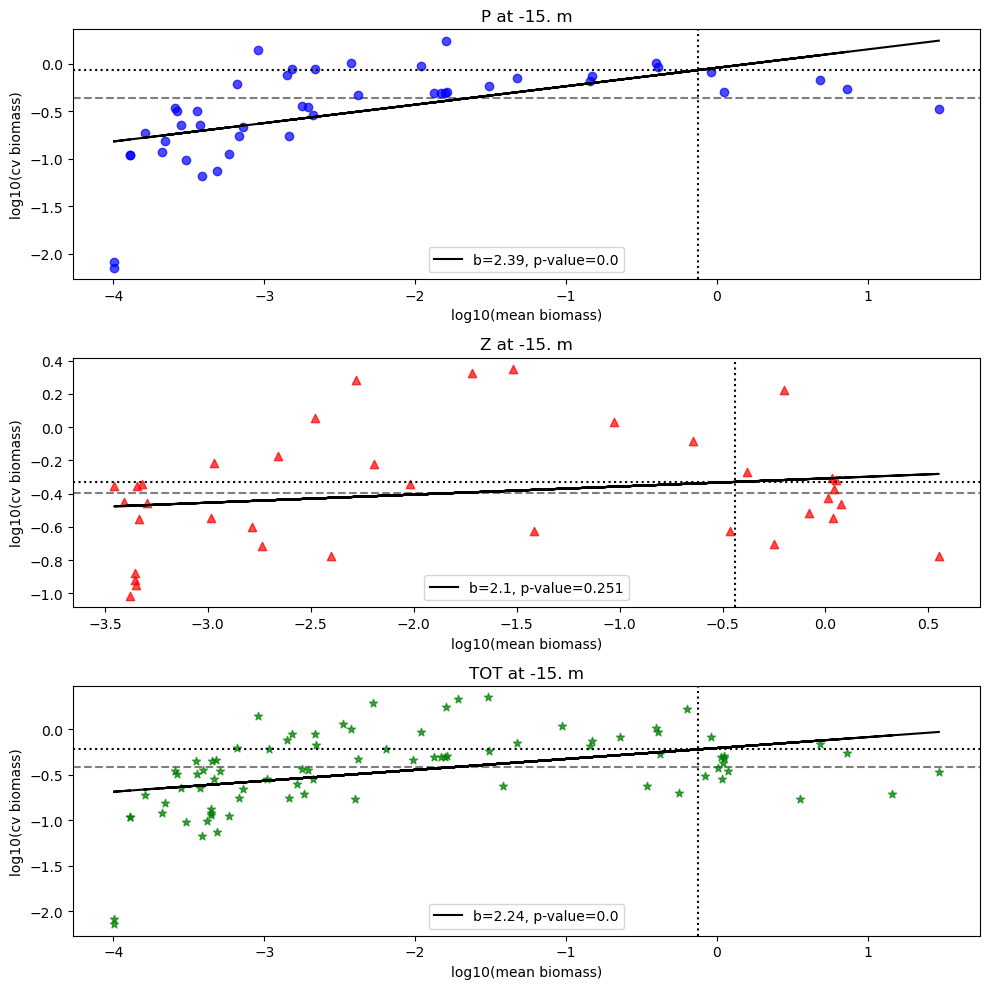

In [32]:
#Plot of the Taylor's power law
from scipy.stats import pearsonr
fig, axs = plt.subplots(3,1,figsize=(10,10))
#layer of deth at which the power law will be calculated
z_layer = 15
iz= np.argmin(np.abs(depth+z_layer))
for icomm,community in enumerate(communities):
        #mean biomass (species,time,depth)
        mean_biomass = np.nanmean(ds[community][:,:,iz],axis=1)
        cv_biomass   = np.nanstd(ds[community][:,:,iz],axis=1)/np.nanmean(ds[community][:,:,iz],axis=1)
        var_biomass  = np.nanvar(ds[community][:,:,iz],axis=1)
        #subtitute zeros in cv_biomass with nan otherwise the log10 will return -inf
        mean_biomass[cv_biomass==0] = np.nan
        var_biomass[cv_biomass==0] = np.nan
        cv_biomass[cv_biomass==0] = np.nan

        TPL = np.polyfit(np.log10(mean_biomass[~np.isnan(mean_biomass)]), np.log10(cv_biomass[~np.isnan(cv_biomass)]), 1)
        _, p = pearsonr(np.log10(mean_biomass[~np.isnan(mean_biomass)]), np.log10(cv_biomass[~np.isnan(cv_biomass)]))
        meansum = np.nanmean(np.nansum(ds[community][:,:,iz],axis=0))
        varsum = np.nanvar(np.nansum(ds[community][:,:,iz],axis=0))
        cvsum = np.sqrt(varsum)/meansum
        n = ds[community][:,:,iz].shape[0]
        CVe = 10**TPL[1] * (meansum / n)**TPL[0]
        sumsd = np.nansum(np.sqrt(var_biomass))
        CVtilde = sumsd / meansum

        axs[icomm].scatter(np.log10(mean_biomass),np.log10(cv_biomass),marker=markers[icomm],c=colors[icomm],alpha=0.7)
        
        axs[icomm].plot(np.log10(mean_biomass),TPL[0]*np.log10(mean_biomass)+TPL[1],c='k',label='b='+str(round((TPL[0]+1)*2,2))+', p-value='+str(round(p,3)))

        axs[icomm].axhline(np.log10(CVtilde),c='k',ls='--',zorder=0,alpha=0.5)
        axs[icomm].axvline(np.log10(meansum/n),c='k',ls=':',zorder=2)
        axs[icomm].axhline(np.log10(CVe),c='k',ls=':',zorder=1)
            
        axs[icomm].set_title(community+' at '+str(round(depth[iz], 3))[:4]+' m')#+' '+str(round(CVe,2))+' '+str(round(cvsum,2)))
        axs[icomm].set_xlabel('log10(mean biomass)')
        axs[icomm].set_ylabel('log10(cv biomass)')
        axs[icomm].legend(loc='lower center')
fig.tight_layout()
